In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import time
from tqdm import tqdm
import scripts.theodolite_utils as tu
import scripts.resection_functions as rf
from scipy import stats
import random as rm
import math
from matplotlib.lines import Line2D


Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

# 27 04 2022
Dist_prism_12_270422 = 0.8856608085851714
Dist_prism_13_270422 = 0.8264452483880412
Dist_prism_23_270422 = 1.0384219210289538
Dist_GPS_12_270422 = 0.7809547832390561
Dist_GPS_13_270422 = 0.8259590286006459
Dist_GPS_23_270422 = 0.5191274645630007  

# 27 04 2022 soir
Dist_prism_12_270422_soir = 0.8868846942534616
Dist_prism_13_270422_soir = 0.829169129877633
Dist_prism_23_270422_soir = 1.0387571594276301
Dist_GPS_12_270422_soir = 0.7837749633840095
Dist_GPS_13_270422_soir = 0.8323125081688734
Dist_GPS_23_270422_soir = 0.5187055120945835

# 05 05 2022
Dist_prism_12_050522 = 0.3819811991689936
Dist_prism_13_050522 = 0.4426382054042266
Dist_prism_23_050522 = 0.2564685508415531

# 13 05 2022
Dist_prism_12_130522 = 0.8113569618671205
Dist_prism_13_130522 = 0.8695313906832193
Dist_prism_23_130522 = 1.0383292631343506
Dist_GPS_12_130522 = 0.7800801192552722
Dist_GPS_13_130522 = 0.8396027021467387
Dist_GPS_23_130522 = 0.5157656903777014

# 23 05 2022
Dist_prism_12_230522 = 0.3851913749758221
Dist_prism_13_230522 = 0.4433899497583272
Dist_prism_23_230522 = 0.25861327466684897

# 25 05 2022
Dist_prism_12_250522 = 0.9095421527752512
Dist_prism_13_250522 = 0.7356677023921305
Dist_prism_23_250522 = 1.0283049452358466

# 22 06 2022
Dist_prism_12_220622 = 0.7359204697527427
Dist_prism_13_220622 = 0.9055056357941131
Dist_prism_23_220622 = 1.0268390664025775

# 30 06 2022
Dist_prism_12_300622 = 0.7297583705742492
Dist_prism_13_300622 = 0.9060320633355149
Dist_prism_23_300622 = 1.0319114860615324

# 11 07 2022
Dist_prism_12_110722 = 0.7290056530579362
Dist_prism_13_110722 = 0.906995998154099
Dist_prism_23_110722 = 1.029264651249632

# 17 07 2022
Dist_prism_12_170722 = 0.39002864329744197 
Dist_prism_13_170722 = 0.4452628757931205 
Dist_prism_23_170722 = 0.2597453130254009

# Comparison between error obtained through resection

The following graph compares the error obtained with the points used for the resection, for all the resection methods.

- distance resection (2 points geomatic)
- control points resection
- dynamic control points resection
  - linear interpolation
  - Gaussian process interpolation
- inter prism distance resection
  - linear interpolation
  - Gaussian process interpolation

In [28]:
# This cell gathers result for the distance resection for the graphic below

rf = importlib.reload(rf)
tu = importlib.reload(tu)

pilier_A = np.array([0, 0, 0, 1]).T
pilier_B = np.array([0, np.sqrt(181.016**2 - 0.323**2), 0.323, 1])
pilier_C = np.array([0, np.sqrt(363.492**2 - 1.038**2), 1.038, 1])
pilier_D = np.array([0, np.sqrt(548.578**2 - 2.374**2), 2.374, 1])
pilier_ref = [pilier_A, pilier_B, pilier_C, pilier_D]

file_name = [
             './data/total_station/20220711/theodolite_reference_prisms_geomatic.txt',
             './data/total_station/20220715/theodolite_reference_prisms_geomatic.txt'
            ]

exp_file_name = [
                './data/prediction/TS/20220711/02/filtered/f-2-1-1-1-6-1-L_',
                 ''
                ]

static_file_name = [
                    './data/total_station/20220711/theodolite_reference_prisms_all.txt',
                    './data/total_station/20220715/theodolite_reference_prisms.txt'
]

inter_prism_dist = [[Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722],
                    []
                   ]

saving_file_path = [
                    '20220711/distance_resection/',
                    '20220715/distance_resection/',
]

save_results = False

error_distance_resection = []
error_distance_resection_exp = []
error_distance_resection_cp = []
TF_list_distance_resection = []
for i,j,k,l,m in zip(file_name, exp_file_name, inter_prism_dist, static_file_name, saving_file_path):    
    TF1,TF2,TF3,error_all_distance_resection,error_distance_cp,error_distance_resection_experiment = rf.geomatic_resection_errors_angle_based(i, pilier_ref, j, k, l)
    error_distance_resection += error_all_distance_resection
    error_distance_resection_exp += error_distance_resection_experiment
    error_distance_resection_cp += error_distance_cp
    TF_list_distance_resection += [TF1, TF2, TF3]
    if(save_results):
        tu.save_error_list_to_file(error_distance_cp, m+"error_distance_resection_cp")
        tu.save_error_list_to_file(error_distance_resection_experiment, m+"error_distance_resection_experiment")
        tu.save_tf_list_to_file([[TF1, TF2, TF3]], m+"TF_list_distance_resection")
        

In [3]:
# This cell gathers result for the static control points for the graphic below

rf = importlib.reload(rf)
tu = importlib.reload(tu)

static_file_name = [
#                     './data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
#                     './data/total_station/20220307/theodolite_reference_prisms.txt',
#                     './data/total_station/20220314/theodolite_reference_prisms.txt',
#                     './data/total_station/20220316/theodolite_reference_prisms.txt',
#                     './data/total_station/20220331-1/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_morning_lidar/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220513_morning_without_lidar_1/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220513_morning_without_lidar_2/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220513_evening_lidar/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_evening_without_lidar_2/theodolite_reference_prisms.txt',
#                     './data/total_station/20220622-1/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220622-2/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt',
#                     './data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt',
#                     './data/total_station/20220711/theodolite_reference_prisms_all.txt',
#                     './data/total_station/20220715/theodolite_reference_prisms.txt'
                    
                    './data/total_station/20220331-2/theodolite_reference_prisms.txt',
                    './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
                    './data/total_station/20220505_empty/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_cones/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_constrained/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_empty/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_other_tunnel/theodolite_reference_prisms.txt',
                    './data/total_station/20220717/theodolite_reference_prisms.txt'
                   ]

name_param_file = 'f-2-1-1-1-6-1-L_'

exp_file_name = [
#                 './data/prediction/TS/20220224/filtered/'+name_param_file,
#                 './data/prediction/TS/20220307/filtered/'+name_param_file,
#                 './data/prediction/TS/20220314/filtered/'+name_param_file,
#                 './data/prediction/TS/20220316/filtered/'+name_param_file,
#                 './data/prediction/TS/20220331-1/filtered/'+name_param_file,
#                 './data/prediction/TS/20220513/01/filtered/'+name_param_file,
#                 './data/prediction/TS/20220513/02/filtered/'+name_param_file,
#                 './data/prediction/TS/20220513/03/filtered/'+name_param_file,
#                 './data/prediction/TS/20220513/04/filtered/'+name_param_file,
#                 './data/prediction/TS/20220513/06/filtered/'+name_param_file,
#                 './data/prediction/TS/20220622-1/filtered/'+name_param_file,
#                 './data/prediction/TS/20220622-2/filtered/'+name_param_file,
#                 './data/prediction/TS/20220630-1/filtered/'+name_param_file,
#                 './data/prediction/TS/20220630-2/filtered/'+name_param_file,
#                 './data/prediction/TS/20220711/02/filtered/'+name_param_file,
                ''
                
                './data/prediction/TS/20220331-2/filtered/'+name_param_file,    
                './data/prediction/TS/20220505_cones/filtered/'+name_param_file,
                './data/prediction/TS/20220505_empty/filtered/'+name_param_file,
                './data/prediction/TS/20220523_cones/filtered/'+name_param_file,
                './data/prediction/TS/20220523_constrained/filtered/'+name_param_file,
                './data/prediction/TS/20220523_empty/filtered/'+name_param_file,
                './data/prediction/TS/20220523_other_tunnel/filtered/'+name_param_file,
                './data/prediction/TS/20220717/02/filtered/'+name_param_file
                ]

Inter_prism_dist = [
#                   [Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
#                   [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
#                   [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
#                   [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
#                   [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],              
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
#                   [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
#                   [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
#                   [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
#                   [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722],
#                   []
                  
                  [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                  [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                  [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722]
                   ]

saving_file_path = [
#                     '20220224/',
#                     '20220307/',
#                     '20220314/',
#                     '20220316/',
#                     '20220331/01/',
#                     '20220513/morning_lidar/',
#                     '20220513/morning_without_lidar_1/',
#                     '20220513/morning_without_lidar_2/',
#                     '20220513/evening_lidar/',
#                     '20220513/evening_without_lidar_2/',
#                     '20220622/01/',
#                     '20220622/02/',
#                     '20220630/01/',
#                     '20220630/02/',
#                     '20220711/',
#                     '20220715/'
    
                    '20220331/02/',  
                    '20220505/cones/',
                    '20220505/empty/',
                    '20220523/cones/',
                    '20220523/constrained/',
                    '20220523/empty/',
                    '20220523/other_tunnel/',
                    '20220717/'
                   ]

save_results = False

errors_static_cp = []
error_inter_prism_exp_cp = []
TF_list_static = []
for i,j,k,l in zip(static_file_name, exp_file_name, Inter_prism_dist, saving_file_path):
    print("don't give up: ", i)
    errors_cp, error_inter_prism_cp, TF_list = rf.static_control_points_error(static_file_path=i, exp_file_path=j, inter_prism_dist=k)
    errors_static_cp += errors_cp
    error_inter_prism_exp_cp += error_inter_prism_cp
    TF_list_static += TF_list
    if(save_results):
        tu.save_error_list_to_file(errors_cp, l+"error_static_cp_cp")
        tu.save_error_list_to_file(error_inter_prism_cp, l+"error_static_cp_experiment")
        tu.save_tf_list_to_file(TF_list, l+"TF_list_static_cp")
        

don't give up:  ./data/total_station/20220331-2/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220505_cones/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220505_empty/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220523_cones/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220523_constrained/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220523_empty/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220523_other_tunnel/theodolite_reference_prisms.txt
don't give up:  ./data/total_station/20220717/theodolite_reference_prisms.txt


In [30]:
# This cell gathers result for the dynamic control points for the graphic below
# With a linear interpolation

rf = importlib.reload(rf)

name_param_file = 'f-2-1-1-1-6-1-L'

linear_dynamic_cp_file_name = [
                               './data/prediction/TS/20220711/01/filtered/'+name_param_file,
                               './data/prediction/TS/20220715/02/filtered/'+name_param_file,
                               './data/prediction/TS/20220715/03/filtered/'+name_param_file,
                               './data/prediction/TS/20220717/05/filtered/'+name_param_file
                              ]

exp_file_name = [
                 './data/prediction/TS/20220711/02/filtered/'+name_param_file+'_',
                 '',
                 '',
                 './data/prediction/TS/20220717/02/filtered/'+name_param_file+'_'
                ]

file_name_marker = [
                    './data/total_station/20220711/theodolite_reference_prisms_1_to_10.txt',
                    './data/total_station/20220715/theodolite_reference_prisms.txt',
                    './data/total_station/20220715/theodolite_reference_prisms.txt',
                    './data/total_station/20220717/theodolite_reference_prisms.txt'
                   ]

Inter_prism_dist = [
                    [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722],
                    [],
                    [],
                    [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722]
                   ]

saving_file_path = [
                    '20220711/01/',
                    '20220715/02/',
                    '20220715/03/',
                    '20220717/05/',
                   ]

velocity_outlier = [
    2,2,2,2
]

save_results = False

errors_linear_dynamic = []
errors_linear_dynamic_cp = []
errors_linear_dynamic_cp_exp = []
TF_list_linear_dynamic = []
for i,j,k,l,m,n in zip(linear_dynamic_cp_file_name, exp_file_name, file_name_marker, Inter_prism_dist, saving_file_path,velocity_outlier):
    print("dont give up! It: ", i)
    errors_dynamic, errors_dynamic_cp, errors_dynamic_cp_exp, TF_list = rf.dynamic_control_points_error_comparison(dynamic_file_path=i, 
                                            exp_file_path=j, marker_file_path=k, inter_prism_dist=l, 
                                            rate = 10, velocity_outlier = n)
    print("Cp error: ",np.median(errors_dynamic_cp),np.std(errors_dynamic_cp))
    print("Inter-prism: ", np.median(errors_dynamic_cp_exp),np.std(errors_dynamic_cp_exp))
    errors_linear_dynamic += errors_dynamic
    errors_linear_dynamic_cp += errors_dynamic_cp
    errors_linear_dynamic_cp_exp += errors_dynamic_cp_exp
    TF_list_linear_dynamic += TF_list
    if(save_results):
        tu.save_error_list_to_file(errors_dynamic_cp, m+"errors_linear_dynamic_cp_cp")
        tu.save_error_list_to_file(errors_dynamic_cp_exp, m+"errors_linear_dynamic_cp_experiment")
        tu.save_tf_list_to_file(TF_list, m+"TF_list_linear_dynamic_cp")

dont give up! It:  ./data/prediction/TS/20220711/01/filtered/f-2-1-1-1-6-1-L
Cp error:  20.119287487447522 16.093561995321902
Inter-prism:  2.8350070402508587 17.074339582421082
dont give up! It:  ./data/prediction/TS/20220715/02/filtered/f-2-1-1-1-6-1-L
Cp error:  2.9050203388984683 0.9866104072551493
Inter-prism:  nan nan
dont give up! It:  ./data/prediction/TS/20220715/03/filtered/f-2-1-1-1-6-1-L


/home/norlab/python3-8_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/norlab/python3-8_env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/norlab/python3-8_env/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/norlab/python3-8_env/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/norlab/python3-8_env/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cp error:  3.8799986234893487 1.7532003163621928
Inter-prism:  nan nan
dont give up! It:  ./data/prediction/TS/20220717/05/filtered/f-2-1-1-1-6-1-L
Cp error:  3.019285343100122 3.103437681882208
Inter-prism:  12.951558605497127 19.7399725064858


In [4]:
# This cell gathers result for the inter-prism distance resection for the graphic below
# With a linear interpolation

rf = importlib.reload(rf)

name_param_file = 'f-2-1-1-1-6-1-L_'

linear_inter_prism_file_name = [
#                                 './data/prediction/TS/20220224/filtered/'+name_param_file,    # bad
#                                 './data/prediction/TS/20220307/filtered/'+name_param_file,    # okay
#                                 './data/prediction/TS/20220314/filtered/'+name_param_file,    # okay
#                                 './data/prediction/TS/20220316/filtered/'+name_param_file,    # not great
#                                 './data/prediction/TS/20220331-1/filtered/'+name_param_file,  # okay
#                                 './data/prediction/TS/20220513/01/filtered/'+name_param_file,   # not bad!
#                                 './data/prediction/TS/20220513/02/filtered/'+name_param_file,   # badder
#                                 './data/prediction/TS/20220513/03/filtered/'+name_param_file,   # not great
#                                 './data/prediction/TS/20220513/04/filtered/'+name_param_file,   # best one yet
#                                 './data/prediction/TS/20220513/06/filtered/'+name_param_file,   # okay
#                                 './data/prediction/TS/20220525/01/filtered/'+name_param_file,
#                                 './data/prediction/TS/20220525/02/filtered/'+name_param_file,
#                                 './data/prediction/TS/20220622-1/filtered/'+name_param_file,
#                                 './data/prediction/TS/20220622-2/filtered/'+name_param_file,
#                                 './data/prediction/TS/20220630-1/filtered/'+name_param_file,
#                                 './data/prediction/TS/20220630-2/filtered/'+name_param_file,    # okay
#                                 './data/prediction/TS/20220711/02/filtered/'+name_param_file   # bad
    
                                './data/prediction/TS/20220331-2/filtered/'+name_param_file,  # bad
                                './data/prediction/TS/20220505_cones/filtered/f-2-1-1-1-6-1-L_',  # badder
                                './data/prediction/TS/20220505_empty/filtered/f-2-1-1-1-6-1-L_',  # badder
                                './data/prediction/TS/20220523_cones/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220523_constrained/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220523_empty/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220523_other_tunnel/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220717/02/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220717/03/filtered/f-2-1-1-1-6-1-L_',
                                './data/prediction/TS/20220717/04/filtered/f-2-1-1-1-6-1-L_'
                               ]
file_name_marker = [
#                     './data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
#                     './data/total_station/20220307/theodolite_reference_prisms.txt',
#                     './data/total_station/20220314/theodolite_reference_prisms.txt',
#                     './data/total_station/20220316/theodolite_reference_prisms.txt',
#                     './data/total_station/20220331-1/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_morning_lidar/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_morning_without_lidar_1/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_morning_without_lidar_2/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_evening_lidar/theodolite_reference_prisms.txt',
#                     './data/total_station/20220513_evening_without_lidar_2/theodolite_reference_prisms.txt',
#                     './data/total_station/20220525/theodolite_reference_prisms.txt',
#                     './data/total_station/20220525/theodolite_reference_prisms.txt',
#                     './data/total_station/20220622-1/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220622-2/theodolite_reference_prisms_2.txt',
#                     './data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt',
#                     './data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt',
#                     './data/total_station/20220711/theodolite_reference_prisms_1_to_10.txt'
    
                    './data/total_station/20220331-2/theodolite_reference_prisms.txt',
                    './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
                    './data/total_station/20220505_empty/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_cones/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_constrained/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_empty/theodolite_reference_prisms.txt',
                    './data/total_station/20220523_other_tunnel/theodolite_reference_prisms.txt',
                    './data/total_station/20220717/theodolite_reference_prisms.txt',
                    './data/total_station/20220717/theodolite_reference_prisms.txt',
                    './data/total_station/20220717/theodolite_reference_prisms.txt'
                   ]

Inter_distance = [
#                   [Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
#                   [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
#                   [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
#                   [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
#                   [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
#                   [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],               
#                   [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
#                   [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
#                   [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
#                   [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
#                   [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
#                   [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
#                   [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722]
    
                  [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                  [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                  [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
                  [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
                  [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
                  [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722]
                 ]

saving_file_path = [
#                     '20220224/',
#                     '20220307/',
#                     '20220314/',
#                     '20220316/',
#                     '20220331/01/',
#                     '20220513/morning_lidar/',
#                     '20220513/morning_without_lidar_1/',
#                     '20220513/morning_without_lidar_2/',
#                     '20220513/evening_lidar/',
#                     '20220513/evening_without_lidar_2/',
#                     '20220525/01/',
#                     '20220525/02/',
#                     '20220622/01/',
#                     '20220622/02/',
#                     '20220630/01/',
#                     '20220630/02/',
#                     '20220711/02/'
                    
                    '20220331/02/',
                    '20220505/cones/',
                    '20220505/empty/',
                    '20220523/cones/',
                    '20220523/constrained/',
                    '20220523/empty/',
                    '20220523/other_tunnel/',
                    '20220717/02/',
                    '20220717/03/',
                    '20220717/04/'
                   ]

#velocity_outlier_list = [0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01
#                        ]

velocity_outlier_list = [
#                          1,1,1.5,1,2,
#                          1.5,2,1,1,1.5,
#                          1,1,1,1.5,2,
#                          1,2
                         
                         2,2,2,2,2,
                         2,2,2,2,2                 
]

save_results = True

errors_linear_inter_prism = []
errors_linear_inter_prism_exp = []
errors_linear_cp_exp = []
TF_list_linear_inter_prism = []
for i,j,k,l,m in zip(linear_inter_prism_file_name,file_name_marker,Inter_distance,velocity_outlier_list, saving_file_path):
    
    print("dont give up! It: ", i)

    dist_error,_,errors_prism,_, errors_exp, TF_list = rf.one_inter_prism_resection(Inter_distance=k, 
                            file_name=i, file_name_marker=j, rate=10, 
                            prior = "CP", velocity_outlier = l, threshold_training = 0.75, number_iteration = 1, threshold_marker=1, min_6dof=True)
    print(np.median(errors_prism),np.std(errors_prism))
    errors_linear_inter_prism_exp += dist_error
    errors_linear_cp_exp += errors_prism
    TF_list_linear_inter_prism += TF_list
    errors_linear_inter_prism += errors_prism
    if(save_results):
        tu.save_error_list_to_file(errors_prism, m+"errors_linear_inter_prism_6dof_cp")
        tu.save_error_list_to_file(dist_error, m+"errors_linear_inter_prism_6dof_experiment")
        tu.save_tf_list_to_file(TF_list, m+"TF_list_linear_inter_prism_6dof")
        

dont give up! It:  ./data/prediction/TS/20220331-2/filtered/f-2-1-1-1-6-1-L_
Selected points:  835
`xtol` termination condition is satisfied.
Function evaluations 226, initial cost 1.4492e-08, final cost 6.2069e-09, first-order optimality 4.71e-12.
Time [s]:  2.663691759109497
Results done !
49.47469779842463 32.051771822540374
dont give up! It:  ./data/prediction/TS/20220505_cones/filtered/f-2-1-1-1-6-1-L_
Selected points:  1662
`xtol` termination condition is satisfied.
Function evaluations 302, initial cost 9.3556e-09, final cost 1.4735e-09, first-order optimality 6.65e-12.
Time [s]:  6.714823007583618
Results done !
138.7655726487695 63.29031514319039
dont give up! It:  ./data/prediction/TS/20220505_empty/filtered/f-2-1-1-1-6-1-L_
Selected points:  2504
`xtol` termination condition is satisfied.
Function evaluations 242, initial cost 3.9982e-09, final cost 6.1021e-10, first-order optimality 5.75e-12.
Time [s]:  7.948546886444092
Results done !
134.59896686547472 77.8820187033552
do

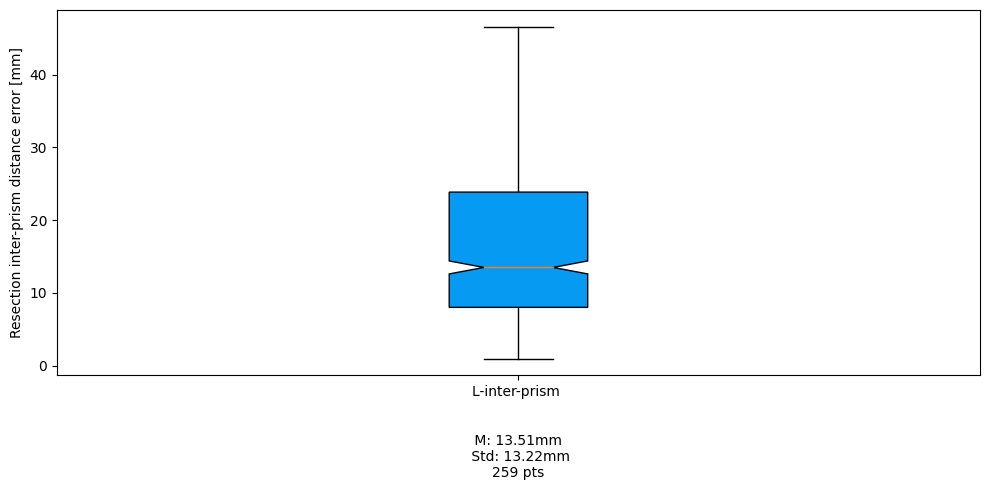

In [37]:
%matplotlib inline

fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
lis = errors_linear_cp_exp

box = ax.boxplot(lis, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1], 
           ["L-inter-prism \n\n\n M: "+str(round(np.median(lis),2))+"mm \n Std: "+str(round(np.std(lis),2))+"mm\n"+str(round(len(lis)/3))+" pts",
           ])
colors_box = ['#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection inter-prism distance error [mm]")
fig.tight_layout()
#fig.savefig("./figs/inter-prism-distance-error-all-4dof.pdf")
plt.show()

In [38]:
# This cell gathers result for the inter-prism distance resection for the graphic below
# With a linear interpolation, and 3 CP only

rf = importlib.reload(rf)

name_param_file = 'f-2-1-1-1-6-1-L_'

linear_inter_prism_file_name = [
                                './data/prediction/TS/20220224/filtered/'+name_param_file,    # bad
                                './data/prediction/TS/20220307/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220314/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220316/filtered/'+name_param_file,    # not great
                                './data/prediction/TS/20220331-1/filtered/'+name_param_file,  # okay
                                './data/prediction/TS/20220513/01/filtered/'+name_param_file,   # not bad!
                                './data/prediction/TS/20220513/02/filtered/'+name_param_file,   # badder
                                './data/prediction/TS/20220513/03/filtered/'+name_param_file,   # not great
                                './data/prediction/TS/20220513/04/filtered/'+name_param_file,   # best one yet
                                './data/prediction/TS/20220513/06/filtered/'+name_param_file,   # okay
                                './data/prediction/TS/20220525/01/filtered/'+name_param_file,
                                './data/prediction/TS/20220525/02/filtered/'+name_param_file,
                                './data/prediction/TS/20220622-1/filtered/'+name_param_file,
                                './data/prediction/TS/20220622-2/filtered/'+name_param_file,
                                './data/prediction/TS/20220630-1/filtered/'+name_param_file,
                                './data/prediction/TS/20220630-2/filtered/'+name_param_file,    # okay
                                './data/prediction/TS/20220711/02/filtered/'+name_param_file   # bad
    
#                                 './data/prediction/TS/20220331-2/filtered/'+name_param_file,  # bad
#                                 './data/prediction/TS/20220505_cones/filtered/f-2-1-1-1-6-1-L_',  # badder
#                                 './data/prediction/TS/20220505_empty/filtered/f-2-1-1-1-6-1-L_',  # badder
#                                 './data/prediction/TS/20220523_cones/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_constrained/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_empty/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220523_other_tunnel/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/02/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/03/filtered/f-2-1-1-1-6-1-L_',
#                                 './data/prediction/TS/20220717/04/filtered/f-2-1-1-1-6-1-L_'
                               ]
file_name_marker = [
                    './data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
                    './data/total_station/20220307/theodolite_reference_prisms.txt',
                    './data/total_station/20220314/theodolite_reference_prisms.txt',
                    './data/total_station/20220316/theodolite_reference_prisms.txt',
                    './data/total_station/20220331-1/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_lidar/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_without_lidar_1/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_morning_without_lidar_2/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_evening_lidar/theodolite_reference_prisms.txt',
                    './data/total_station/20220513_evening_without_lidar_2/theodolite_reference_prisms.txt',
                    './data/total_station/20220525/theodolite_reference_prisms.txt',
                    './data/total_station/20220525/theodolite_reference_prisms.txt',
                    './data/total_station/20220622-1/theodolite_reference_prisms_2.txt',
                    './data/total_station/20220622-2/theodolite_reference_prisms_2.txt',
                    './data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt',
                    './data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt',
                    './data/total_station/20220711/theodolite_reference_prisms_1_to_10.txt'
    
#                     './data/total_station/20220331-2/theodolite_reference_prisms.txt',
#                     './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
#                     './data/total_station/20220505_empty/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_cones/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_constrained/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_empty/theodolite_reference_prisms.txt',
#                     './data/total_station/20220523_other_tunnel/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt',
#                     './data/total_station/20220717/theodolite_reference_prisms.txt'
                   ]

Inter_distance = [
                  [Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                  [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                  [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                  [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                  [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],
                  [Dist_prism_12_130522,Dist_prism_13_130522,Dist_prism_23_130522,Dist_GPS_12_130522,Dist_GPS_13_130522,Dist_GPS_23_130522],               
                  [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
                  [Dist_prism_12_250522,Dist_prism_13_250522,Dist_prism_23_250522],
                  [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
                  [Dist_prism_12_220622,Dist_prism_13_220622,Dist_prism_23_220622],
                  [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                  [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                  [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722]
    
#                   [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
#                   [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
#                   [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_230522,Dist_prism_13_230522,Dist_prism_23_230522],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722],
#                   [Dist_prism_12_170722,Dist_prism_13_170722,Dist_prism_23_170722]
                 ]

saving_file_path = [
                    '20220224/',
                    '20220307/',
                    '20220314/',
                    '20220316/',
                    '20220331/01/',
                    '20220513/morning_lidar/',
                    '20220513/morning_without_lidar_1/',
                    '20220513/morning_without_lidar_2/',
                    '20220513/evening_lidar/',
                    '20220513/evening_without_lidar_2/',
                    '20220525/01/',
                    '20220525/02/',
                    '20220622/01/',
                    '20220622/02/',
                    '20220630/01/',
                    '20220630/02/',
                    '20220711/02/'
                    
#                     '20220331/02/',
#                     '20220505/cones/',
#                     '20220505/empty/',
#                     '20220523/cones/',
#                     '20220523/constrained/',
#                     '20220523/empty/',
#                     '20220523/other_tunnel/',
#                     '20220717/02/',
#                     '20220717/03/',
#                     '20220717/04/'
                   ]

#velocity_outlier_list = [0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01,0.01,
#                        0.01,0.01,0.01,0.01
#                        ]

velocity_outlier_list = [1,1,1.5,1,2,
                         1.5,2,1,1,1.5,
                         1,1,1,1.5,2,
                         1,2
                         
# #                          2,2,2,2,2,
# #                          2,2,2,2                   
]

# velocity_outlier_list = [2            
# ]

save_results = False

errors_linear_inter_prism_3cp = []
errors_linear_inter_prism_exp_3cp = []
errors_linear_cp_exp_3cp = []
TF_list_linear_inter_prism_3cp = []
for i,j,k,l,m in zip(linear_inter_prism_file_name,file_name_marker,Inter_distance,velocity_outlier_list, saving_file_path):
    
    print("dont give up! It: ", i)
    
    dist_error,_,errors_prism,_, errors_exp, TF_list = rf.one_inter_prism_resection(Inter_distance=k, 
                            file_name=i, file_name_marker=j, rate=10, prior = "CP", velocity_outlier = l, 
                            threshold_training = 0.75, number_iteration = 1, threshold_marker=3, min_6dof=True)
    print(np.median(errors_prism),np.std(errors_prism))
    errors_linear_inter_prism_exp_3cp += dist_error
    errors_linear_cp_exp_3cp += errors_prism
    TF_list_linear_inter_prism_3cp += TF_list
    errors_linear_inter_prism_3cp += errors_prism
    if(save_results):
        ttfu.save_error_list_to_file(errors_prism, m+"errors_linear_inter_prism_6dof_cp_3cp")
        ttfu.save_error_list_to_file(dist_error, m+"errors_linear_inter_prism_6dof_experiment_3cp")
        ttfu.save_tf_list_to_file(TF_list, m+"TF_list_linear_inter_prism_6dof_3cp")

dont give up! It:  ./data/prediction/TS/20220224/filtered/f-2-1-1-1-6-1-L_
0
`xtol` termination condition is satisfied.
Function evaluations 160, initial cost 6.0009e-09, final cost 1.0253e-09, first-order optimality 3.37e-12.
Time [s]:  9.446643829345703
Results done !
14.874996309505406 17.036965262850465
dont give up! It:  ./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-L_
0
`xtol` termination condition is satisfied.
Function evaluations 113, initial cost 2.4444e-10, final cost 1.4842e-10, first-order optimality 4.77e-13.
Time [s]:  26.024654388427734
Results done !
8.91881703424398 3.839336712776593
dont give up! It:  ./data/prediction/TS/20220314/filtered/f-2-1-1-1-6-1-L_
0
`xtol` termination condition is satisfied.
Function evaluations 149, initial cost 1.2404e-09, final cost 7.3698e-11, first-order optimality 1.60e-12.
Time [s]:  22.320231437683105
Results done !
15.874609653743367 6.094384909258963
dont give up! It:  ./data/prediction/TS/20220316/filtered/f-2-1-1-1-6-1-L_


/home/norlab/python3-8_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


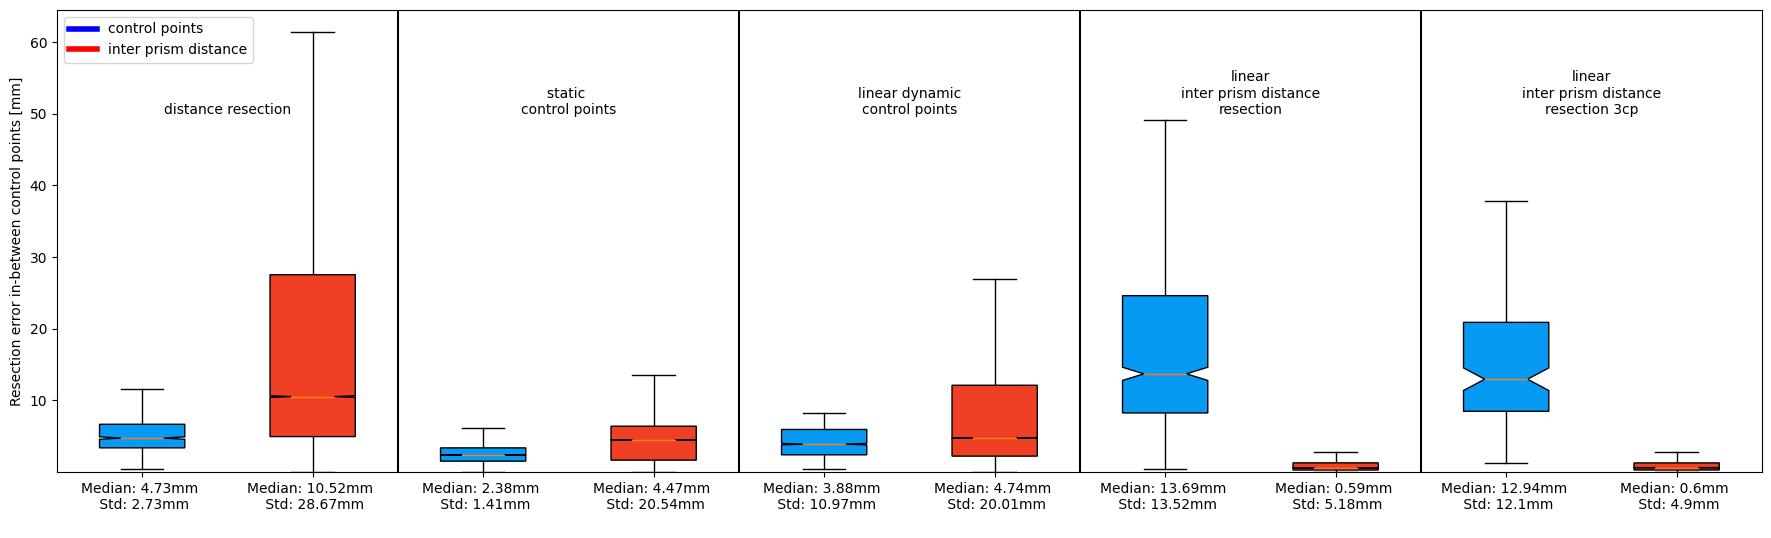

In [27]:
%matplotlib inline

# print(
#       np.shape(error_distance_resection_cp),'\n', 
#       np.shape(error_distance_resection_exp),'\n', 
#       np.shape(errors_static_cp),'\n', 
#       np.shape(error_inter_prism_exp_cp),'\n', 
#       np.shape(errors_linear_dynamic_cp),'\n', 
#       np.shape(errors_linear_dynamic_cp_exp),'\n', 
#       np.shape(errors_gp_dynamic_cp),'\n', 
#       np.shape(errors_gp_dynamic_cp_exp),'\n', 
#       np.shape(errors_linear_inter_prism),'\n', 
#       np.shape(errors_linear_inter_prism_exp),'\n', 
#       np.shape(errors_gp_inter_prism),'\n', 
#       np.shape(error_gp_inter_prism_exp)
#      )

# print(gp_inter_prism_file_name)

fig = plt.figure(figsize =(22, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_distance_resection_cp, error_distance_resection_exp, 
                  errors_static_cp, error_inter_prism_exp_cp, 
                  errors_linear_dynamic_cp, errors_linear_dynamic_cp_exp, 
                  errors_linear_inter_prism, errors_linear_inter_prism_exp,
                  errors_linear_inter_prism_3cp, errors_linear_inter_prism_exp_3cp
                  ], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

plt.xticks([1.5, 3.5, 5.5, 7.5],
           [
               "distance resection",
               "static control points",
               "linear dynamic control points",
               "linear inter prism distance resection",
               "linear inter prism distance resection 3 cp prior"
           ])

plt.xticks([1,2,3,4,5,6,7,8,9,10], ["Median: "+str(round(np.median(error_distance_resection_cp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_distance_resection_exp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_exp),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_static_cp),2))+"mm \n Std: "+str(round(np.std(errors_static_cp),2))+"mm\n", 
                                 "Median: "+str(round(np.median(error_inter_prism_exp_cp),2))+"mm \n Std: "+str(round(np.std(error_inter_prism_exp_cp),2))+"mm\n",                           
                                 "Median: "+str(round(np.median(errors_linear_dynamic_cp),2))+"mm \n Std: "+str(round(np.std(errors_linear_dynamic_cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_linear_dynamic_cp_exp),2))+"mm \n Std: "+str(round(np.std(errors_linear_dynamic_cp_exp),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_linear_inter_prism),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_linear_inter_prism_exp),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism_exp),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_linear_inter_prism_3cp),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism_3cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(errors_linear_inter_prism_exp_3cp),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism_exp_3cp),2))+"mm\n"
                                 ])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
legend_elements = [Line2D([0], [0], color='b', lw=4, label='control points'),
                   Line2D([0], [0], color='r', lw=4, label='inter prism distance')]
plt.text(1.5, 50, "distance resection", horizontalalignment='center')
plt.text(3.5, 50, "static \ncontrol points", horizontalalignment='center')
plt.text(5.5, 50, "linear dynamic\ncontrol points", horizontalalignment='center')
plt.text(7.5, 50, "linear\ninter prism distance\nresection", horizontalalignment='center')
plt.text(9.5, 50, "linear\ninter prism distance\nresection 3cp", horizontalalignment='center')

plt.axvline(x=2.5, color='black')
plt.axvline(x=4.5, color='black')
plt.axvline(x=6.5, color='black')
plt.axvline(x=8.5, color='black')
ax.legend(handles=legend_elements, loc='upper left')
#plt.yscale('log')
plt.ylim(1e-2,)
plt.show()
fig.tight_layout()
fig.savefig("./figs/comparison_resection_method.pdf")
plt.show()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize =(18, 6))
ax = fig.add_subplot(111)

#box = ax.boxplot([error_distance_resection_cp, errors_static_cp, errors_linear_dynamic_cp, errors_gp_dynamic_cp, 
#                  errors_linear_inter_prism, errors_gp_inter_prism], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
box = ax.boxplot([error_distance_resection_cp, errors_static_cp, errors_linear_dynamic_cp, errors_gp_dynamic_cp, 
                  errors_linear_inter_prism], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1,2,3,4,5,6], ["distance \n resection \n (piliers) \n\n\n Median: "+str(round(np.median(error_distance_resection),2))+"mm \n Std: "+str(round(np.std(error_distance_resection),2))+"mm\n"+str(round(len(error_distance_resection)/3))+" points",
                                 "static \n control points \n (1 prisme) \n\n\n Median: "+str(round(np.median(errors_static_cp),2))+"mm \n Std: "+str(round(np.std(errors_static_cp),2))+"mm\n"+str(round(len(errors_static_cp)/60))+" points", 
                                 "dynamic \n control points \n linear interpolation \n (1 prisme) \n\n Median: "+str(round(np.median(errors_linear_dynamic_cp),2))+"mm \n Std: "+str(round(np.std(errors_linear_dynamic_cp),2))+"mm\n"+str(round(len(errors_linear_dynamic_cp)/6))+" points",
                                 "dynamic \n control points \n GP \n (1 prisme)  \n\n Median: "+str(round(np.median(errors_gp_dynamic_cp),2))+"mm \n Std: "+str(round(np.std(errors_gp_dynamic_cp),2))+"mm\n"+str(round(len(errors_gp_dynamic_cp)/6))+" points",
                                 "Inter-prism \n distance resection \n linear interpolation \n (3 prismes) \n\n Median: "+str(round(np.median(errors_linear_inter_prism),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism),2))+"mm\n"+str(round(len(errors_linear_inter_prism)/3))+" points",
                                 ])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
fig.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize =(18, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_distance_resection_exp, error_inter_prism_exp_cp, errors_linear_dynamic_cp_exp, errors_gp_dynamic_cp_exp, 
                errors_linear_inter_prism_exp, error_gp_inter_prism_exp], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1,2,3,4,5,6], ["distance \n resection experiment \n (3 prismes) \n\n\n Median: "+str(round(np.median(error_distance_resection_exp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_exp),2))+"mm\n",
                                 "inter prism distance \n control points \n (3 prisme) \n\n\n Median: "+str(round(np.median(error_inter_prism_exp_cp),2))+"mm \n Std: "+str(round(np.std(error_inter_prism_exp_cp),2))+"mm\n",                           
                                 "dynamic \n experiment \n linear interpolation \n (3 prismes) \n\n Median: "+str(round(np.median(errors_linear_dynamic_cp_exp),2))+"mm \n Std: "+str(round(np.std(errors_linear_dynamic_cp_exp),2))+"mm\n",
                                 "dynamic \n experiment \n GP \n (3 prismes)  \n\n Median: "+str(round(np.median(errors_gp_dynamic_cp_exp),2))+"mm \n Std: "+str(round(np.std(errors_gp_dynamic_cp_exp),2))+"mm\n",
                                 "Inter-prism \n distance experiment \n linear interpolation \n (3 prismes) \n\n Median: "+str(round(np.median(errors_linear_inter_prism_exp),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism_exp),2))+"mm\n",
                                 "Inter-prism \n distance experiment \n GP \n (3 prismes) \n\n Median: "+str(round(np.median(error_gp_inter_prism_exp),2))+"mm \n Std: "+str(round(np.std(error_gp_inter_prism_exp),2))+"mm\n"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
fig.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

# print(error_distance_resection)

# print(error_distance_resection_cp)

# print(error_distance_resection_exp)

fig = plt.figure(figsize =(18, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_distance_resection, error_distance_resection_exp, error_distance_resection_cp], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1,2,3], ["distance \n resection \n (1 prisme) \n\n Median: "+str(round(np.median(error_distance_resection),2))+"mm \n Std: "+str(round(np.std(error_distance_resection),2))+"mm\n",
                           "distance \n resection experiment \n (3 prismes) \n\n Median: "+str(round(np.median(error_distance_resection_exp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_exp),2))+"mm\n",
                           "distance \n resection control points \n (1 prisme) \n\n Median: "+str(round(np.median(error_distance_resection_cp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_cp),2))+"mm\n"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
fig.tight_layout()
plt.show()

In [ ]:
print('T1_static: \n', TF_list_static[0][0])
print('T12_static: \n', TF_list_static[0][1])
print('T13_static: \n', TF_list_static[0][2])

In [ ]:
print('T1_dynamic_linear: \n', TF_list_linear_dynamic[0][0])
print('T12_dynamic_linear: \n', TF_list_linear_dynamic[0][1])
print('T13_dynamic_linear: \n', TF_list_linear_dynamic[0][2])

In [ ]:
print('T1_dynamic_gp: \n', TF_list_gp_dynamic[0][0])
print('T12_dynamic_gp: \n', TF_list_gp_dynamic[0][1])
print('T13_dynamic_gp: \n', TF_list_gp_dynamic[0][2])

In [ ]:
print('T1_inter_prism_linear: \n', TF_list_linear_inter_prism[0][0])
print('T12_inter_prism_linear: \n', TF_list_linear_inter_prism[0][1])
print('T13_inter_prism_linear: \n', TF_list_linear_inter_prism[0][2])

In [ ]:
print('T1_inter_prism_gp: \n', TF_list_gp_inter_prism[0][0])
print('T12_inter_prism_gp: \n', TF_list_gp_inter_prism[0][1])
print('T13_inter_prism_gp: \n', TF_list_gp_inter_prism[0][2])

In [ ]:
pos_TS2_static = TF_list_static[0][1][:3,3]
pos_TS3_static = TF_list_static[0][2][:3,3]

pos_TS2_dynamic_linear = TF_list_linear_dynamic[0][1][:3,3]
pos_TS3_dynamic_linear = TF_list_linear_dynamic[0][2][:3,3]

pos_TS2_dynamic_gp = TF_list_gp_dynamic[0][1][:3,3]
pos_TS3_dynamic_gp = TF_list_gp_dynamic[0][2][:3,3]

pos_TS2_inter_prism_linear = TF_list_linear_inter_prism[0][1][:3,3]
pos_TS3_inter_prism_linear = TF_list_linear_inter_prism[0][2][:3,3]

pos_TS2_inter_prism_gp = TF_list_gp_inter_prism[0][1][:3,3]
pos_TS3_inter_prism_gp = TF_list_gp_inter_prism[0][2][:3,3]

print('dist TS2-static-linear-dynamic :', np.linalg.norm(pos_TS2_static-pos_TS2_dynamic_linear)*1000, 'mm')
print('dist TS3-static-linear-dynamic :', np.linalg.norm(pos_TS3_static-pos_TS3_dynamic_linear)*1000, 'mm')
print('dist TS2-static-gp-dynamic :', np.linalg.norm(pos_TS2_static-pos_TS2_dynamic_gp)*1000, 'mm')
print('dist TS3-static-gp-dynamic :', np.linalg.norm(pos_TS3_static-pos_TS3_dynamic_gp)*1000, 'mm')
print('dist TS2-static-linear-inter_prism :', np.linalg.norm(pos_TS2_static-pos_TS2_inter_prism_linear)*1000, 'mm')
print('dist TS3-static-linear-inter_prism :', np.linalg.norm(pos_TS3_static-pos_TS3_inter_prism_linear)*1000, 'mm')
print('dist TS2-static-gp-inter_prism :', np.linalg.norm(pos_TS2_static-pos_TS2_inter_prism_gp)*1000, 'mm')
print('dist TS3-static-gp-inter_prism :', np.linalg.norm(pos_TS3_static-pos_TS3_inter_prism_gp)*1000, 'mm')

In [ ]:
rot_dist_TS2_dynamic_linear = np.arccos((np.trace(TF_list_static[0][1][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_linear_dynamic[0][1][:3,:3]) - 1) / 2)
print('rot_dist_TS2-static-linear-dynamic: ', rot_dist_TS2_dynamic_linear, 'rad')
# TF2_stat = TF_list_static[0][1][:3,:3]
# TF2_lin_dyn = TF_list_linear_dynamic[0][1][:3,:3]
# TF2_lin_dyn_t = TF2_lin_dyn.T
# TF_to_test = TF2_lin_dyn_t@TF2_stat
# rot_dist_TS2_dynamic_linear = np.arccos((np.trace(TF_to_test) - 1) / 2)
# print('rot_dist_TS2-static-linear-dynamic: ', rot_dist_TS2_dynamic_linear, 'rad')
rot_dist_TS3_dynamic_linear = np.arccos((np.trace(TF_list_static[0][2][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_linear_dynamic[0][2][:3,:3]) - 1) / 2)
print('rot_dist_TS3-static-linear-dynamic: ', rot_dist_TS3_dynamic_linear, 'rad')
rot_dist_TS2_dynamic_gp = np.arccos((np.trace(TF_list_static[0][1][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_gp_dynamic[0][1][:3,:3]) - 1) / 2)
print('rot_dist_TS2-static-gp-dynamic: ', rot_dist_TS2_dynamic_linear, 'rad')
rot_dist_TS3_dynamic_gp = np.arccos((np.trace(TF_list_static[0][2][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_gp_dynamic[0][2][:3,:3]) - 1) / 2)
print('rot_dist_TS3-static-gp-dynamic: ', rot_dist_TS3_dynamic_linear, 'rad')
rot_dist_TS2_inter_prism_linear = np.arccos((np.trace(TF_list_static[0][1][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_linear_inter_prism[0][1][:3,:3]) - 1) / 2)
print('rot_dist_TS2-static-linear-inter-prism: ', rot_dist_TS2_inter_prism_linear, 'rad')
rot_dist_TS3_inter_prism_linear = np.arccos((np.trace(TF_list_static[0][2][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_linear_inter_prism[0][2][:3,:3]) - 1) / 2)
print('rot_dist_TS3-static-linear-inter-prism: ', rot_dist_TS3_inter_prism_linear, 'rad')
rot_dist_TS2_inter_prism_gp = np.arccos((np.trace(TF_list_static[0][1][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_gp_inter_prism[0][1][:3,:3]) - 1) / 2)
print('rot_dist_TS2-static-gp-inter-prism: ', rot_dist_TS2_inter_prism_gp, 'rad')
rot_dist_TS3_inter_prism_gp = np.arccos((np.trace(TF_list_static[0][2][:3,:3]) - 1) / 2) - np.arccos((np.trace(TF_list_gp_inter_prism[0][2][:3,:3]) - 1) / 2)
print('rot_dist_TS3-static-gp-inter-prism: ', rot_dist_TS3_inter_prism_gp, 'rad')

# Next section will plot the control points with a color map based on the error obtained on each of them.

In [ ]:
marker_file_name = './data/total_station/20220711/theodolite_reference_prisms_all.txt'
ts1_static, ts2_static, ts3_static, T1_static, T12_static, T13_static = ttfu.read_marker_file(file_name=marker_file_name, theodolite_reference_frame=1)

cp1 = ts1_static
cp2 = (T12_static @ ts2_static)
cp3 = (T13_static @ ts3_static)
error_lin_dyn = []
error_gp_dyn = []
error_lin_ip = []
error_gp_ip = []

cp1_t = cp1.T
for i in range(len(cp1[0])):
    error_lin_dyn.append(np.mean([errors_linear_dynamic_cp[0+3*i], errors_linear_dynamic_cp[1+3*i], errors_linear_dynamic_cp[2+3*i]])/np.linalg.norm(cp1_t[i]))
    error_gp_dyn.append(np.mean([errors_gp_dynamic_cp[0+3*i], errors_gp_dynamic_cp[1+3*i], errors_gp_dynamic_cp[2+3*i]])/np.linalg.norm(cp1_t[i]))
    error_lin_ip.append(np.mean([errors_linear_inter_prism[0+3*i], errors_linear_inter_prism[1+3*i], errors_linear_inter_prism[2+3*i]])/np.linalg.norm(cp1_t[i]))
    error_gp_ip.append(np.mean([errors_gp_inter_prism[0+3*i], errors_gp_inter_prism[1+3*i], errors_gp_inter_prism[2+3*i]])/np.linalg.norm(cp1_t[i]))

In [ ]:
fig = plt.figure(figsize=(10,7))
scat1=plt.scatter([cp1[0]], [cp1[1]], c=error_lin_ip, cmap='viridis')
fig.colorbar(scat1)
fig.suptitle('Error on the control points in mm', fontsize=16)
plt.show

In [ ]:
fig = plt.figure(figsize=(10,7))
scat1=plt.scatter([cp1[0]], [cp1[1]], c=error_gp_ip, cmap='viridis')
fig.colorbar(scat1)
fig.suptitle('Error on the control points in mm', fontsize=16)
plt.show

In [ ]:
fig = plt.figure(figsize=(10,7))
scat1=plt.scatter([cp1[0]], [cp1[1]], c=error_lin_dyn, cmap='viridis')
fig.colorbar(scat1)
fig.suptitle('Error on the control points in mm', fontsize=16)
plt.show

In [ ]:
fig = plt.figure(figsize=(10,7))
scat1=plt.scatter([cp1[0]], [cp1[1]], c=error_gp_dyn, cmap='viridis')
fig.colorbar(scat1)
fig.suptitle('Error on the control points in mm', fontsize=16)
plt.show

# Generate the list variables from the error lists saved in .csv format

In [ ]:
# This cell generates the distance resection error lists.
reading_file_path = [
                    './data/error_lists/20220711/distance_resection/',
                    './data/error_lists/20220715/distance_resection/',
]

resection_type = 'error_distance_resection_'

error_distance_resection_cp = []
error_distance_resection_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_distance_resection_cp += error_cp
    error_distance_resection_experiment += error_exp

print(len(error_distance_resection_cp))
print(len(error_distance_resection_experiment))

In [ ]:
# This cell generates the static control points resection error lists.
reading_file_path = [
                    './data/error_lists/20220224/',
                    './data/error_lists/20220307/',
                    # # './data/error_lists/20220312/',
                    './data/error_lists/20220314/',
                    './data/error_lists/20220316/',
                    # './data/error_lists/20220331/01/',
                    './data/error_lists/20220331/02/',
                    # # './data/error_lists/20220427/morning/',
                    # # './data/error_lists/20220427/evening/01/',
                    # # './data/error_lists/20220427/evening/02/',
                    # './data/error_lists/20220505/cones/',
                    './data/error_lists/20220505/empty/',
                    './data/error_lists/20220513/morning_lidar/01/',
                    # './data/error_lists/20220513/morning_lidar/02/',
                    './data/error_lists/20220513/morning_without_lidar_1/',
                    './data/error_lists/20220513/morning_without_lidar_2/',
                    './data/error_lists/20220513/evening_lidar/',
                    # # './data/error_lists/20220513/evening_without_lidar_1/',
                    './data/error_lists/20220513/evening_without_lidar_2/',
                    # './data/error_lists/20220523/cones/',
                    './data/error_lists/20220523/constrained/',
                    './data/error_lists/20220523/empty/',
                    # './data/error_lists/20220523/other_tunnel/',
                    './data/error_lists/20220622/01/01/',
                    # './data/error_lists/20220622/01/02/',
                    './data/error_lists/20220622/02/01/',
                    './data/error_lists/20220622/02/02/',
                    './data/error_lists/20220630/01/',
                    './data/error_lists/20220630/02/',
                    './data/error_lists/20220711/',
                    './data/error_lists/20220715/',
                    './data/error_lists/20220717/02/'
                   ]

resection_type = 'error_static_cp_'

error_static_cp_cp = []
error_static_cp_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_static_cp_cp += error_cp
    error_static_cp_experiment += error_exp

print(len(error_static_cp_cp))
print(len(error_static_cp_experiment))

In [ ]:
# This cell generates the GP dynamic CP resection error list
reading_file_path = [
                     # '20201008/01/',
                    './data/error_lists/20220711/01/',
                    './data/error_lists/20220715/02/',
                    './data/error_lists/20220715/03/',
                    './data/error_lists/20220717/05/',
                   ]

resection_type = 'errors_gp_dynamic_cp_'

error_gp_dynamic_cp_cp = []
error_gp_dynamic_cp_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_gp_dynamic_cp_cp += error_cp
    error_gp_dynamic_cp_experiment += error_exp

print(len(error_gp_dynamic_cp_cp))
print(len(error_gp_dynamic_cp_experiment))

In [ ]:
# This cell generates the linear dynamic CP resection error list
reading_file_path = [
                     # '20201008/01/',
                    './data/error_lists/20220711/01/',
                    './data/error_lists/20220715/02/',
                    './data/error_lists/20220715/03/',
                    './data/error_lists/20220717/05/',
                   ]

resection_type = 'errors_linear_dynamic_cp_'

error_linear_dynamic_cp_cp = []
error_linear_dynamic_cp_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_linear_dynamic_cp_cp += error_cp
    error_linear_dynamic_cp_experiment += error_exp

print(len(error_linear_dynamic_cp_cp))
print(len(error_linear_dynamic_cp_experiment))

In [ ]:
# This cell generates the GP inter prism distance resection error list
reading_file_path = [
                    './data/error_lists/20220224/',
                    './data/error_lists/20220307/',
                    # './data/error_lists/20220312/',
                    './data/error_lists/20220314/',
                    './data/error_lists/20220316/',
                    './data/error_lists/20220331/01/',
                    './data/error_lists/20220331/02/',
                    # './data/error_lists/20220427/morning/',
                    './data/error_lists/20220505/cones/',
                    './data/error_lists/20220505/empty/',
                    './data/error_lists/20220513/morning_lidar/',
                    './data/error_lists/20220513/morning_without_lidar_1/',
                    './data/error_lists/20220513/morning_without_lidar_2/',
                    './data/error_lists/20220513/evening_lidar/',
                    # '20220513/evening_without_lidar_1/',
                    './data/error_lists/20220513/evening_without_lidar_2/',
                    './data/error_lists/20220523/cones/',
                    './data/error_lists/20220523/constrained/',
                    './data/error_lists/20220523/empty/',
                    './data/error_lists/20220523/other_tunnel/',
                    './data/error_lists/20220525/01/',
                    './data/error_lists/20220525/02/',
                    './data/error_lists/20220622/01/',
                    './data/error_lists/20220622/02/',
                    './data/error_lists/20220630/01/',
                    './data/error_lists/20220630/02/',
                    './data/error_lists/20220711/',
                    './data/error_lists/20220717/02/',
                    './data/error_lists/20220717/03/',
                    './data/error_lists/20220717/04/'
                   ]

resection_type = 'errors_gp_inter_prism_'

error_gp_inter_prism_cp = []
error_gp_inter_prism_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_gp_inter_prism_cp += error_cp
    error_gp_inter_prism_experiment += error_exp

print(len(error_gp_inter_prism_cp))
print(len(error_gp_inter_prism_experiment))

In [ ]:
# This cell generates the linear inter prism distance resection error list
reading_file_path = [
                    './data/error_lists/20220224/',
                    './data/error_lists/20220307/',
                    # './data/error_lists/20220312/',
                    './data/error_lists/20220314/',
                    './data/error_lists/20220316/',
                    './data/error_lists/20220331/01/',
                    './data/error_lists/20220331/02/',
                    # './data/error_lists/20220427/morning/',
                    './data/error_lists/20220505/cones/',
                    './data/error_lists/20220505/empty/',
                    './data/error_lists/20220513/morning_lidar/',
                    './data/error_lists/20220513/morning_without_lidar_1/',
                    './data/error_lists/20220513/morning_without_lidar_2/',
                    './data/error_lists/20220513/evening_lidar/',
                    # '20220513/evening_without_lidar_1/',
                    './data/error_lists/20220513/evening_without_lidar_2/',
                    './data/error_lists/20220523/cones/',
                    './data/error_lists/20220523/constrained/',
                    './data/error_lists/20220523/empty/',
                    './data/error_lists/20220523/other_tunnel/',
                    './data/error_lists/20220525/01/',
                    './data/error_lists/20220525/02/',
                    './data/error_lists/20220622/01/',
                    './data/error_lists/20220622/02/',
                    './data/error_lists/20220630/01/',
                    './data/error_lists/20220630/02/',
                    './data/error_lists/20220711/',
                    './data/error_lists/20220717/02/',
                    './data/error_lists/20220717/03/',
                    './data/error_lists/20220717/04/'
                   ]

resection_type = 'errors_linear_inter_prism_6dof_'

error_linear_inter_prism_cp = []
error_linear_inter_prism_experiment = []

for i in reading_file_path:
    error_cp, error_exp = ttfu.read_error_list_file(i+resection_type)
    error_linear_inter_prism_cp += error_cp
    error_linear_inter_prism_experiment += error_exp

print(len(error_linear_inter_prism_cp))
print(len(error_linear_inter_prism_experiment))

In [ ]:
%matplotlib inline

# print(
#       np.shape(error_distance_resection_cp),'\n', 
#       np.shape(error_distance_resection_experiment),'\n', 
#       np.shape(error_static_cp_cp),'\n', 
#       np.shape(error_static_cp_experiment),'\n', 
#       np.shape(error_linear_dynamic_cp_cp),'\n', 
#       np.shape(error_linear_dynamic_cp_experiment),'\n', 
#       np.shape(error_gp_dynamic_cp_cp),'\n', 
#       np.shape(error_gp_dynamic_cp_experiment),'\n', 
#       np.shape(error_linear_inter_prism_cp),'\n', 
#       np.shape(error_linear_inter_prism_experiment),'\n', 
#       np.shape(error_gp_inter_prism_cp),'\n', 
#       np.shape(error_gp_inter_prism_experiment)
#      )

# print(max(error_linear_dynamic_cp_cp))

fig = plt.figure(figsize =(22, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_distance_resection_cp, error_distance_resection_experiment, error_static_cp_cp, error_static_cp_experiment, error_linear_dynamic_cp_cp, error_linear_dynamic_cp_experiment, 
                  error_linear_inter_prism_cp, error_linear_inter_prism_experiment], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

plt.xticks([1,2,3,4,5,6,7,8], ["Median: "+str(round(np.median(error_distance_resection_cp),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_distance_resection_experiment),2))+"mm \n Std: "+str(round(np.std(error_distance_resection_experiment),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_static_cp_cp),2))+"mm \n Std: "+str(round(np.std(error_static_cp_cp),2))+"mm\n", 
                                 "Median: "+str(round(np.median(error_static_cp_experiment),2))+"mm \n Std: "+str(round(np.std(error_static_cp_experiment),2))+"mm\n",                           
                                 "Median: "+str(round(np.median(error_linear_dynamic_cp_cp),2))+"mm \n Std: "+str(round(np.std(error_linear_dynamic_cp_cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_linear_dynamic_cp_experiment),2))+"mm \n Std: "+str(round(np.std(error_linear_dynamic_cp_experiment),2))+"mm\n",
                                 # "Median: "+str(round(np.median(error_gp_dynamic_cp_cp),2))+"mm \n Std: "+str(round(np.std(error_gp_dynamic_cp_cp),2))+"mm\n",
                                 # "Median: "+str(round(np.median(error_gp_dynamic_cp_experiment),2))+"mm \n Std: "+str(round(np.std(error_gp_dynamic_cp_experiment),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_linear_inter_prism_cp),2))+"mm \n Std: "+str(round(np.std(error_linear_inter_prism_cp),2))+"mm\n",
                                 "Median: "+str(round(np.median(error_linear_inter_prism_experiment),2))+"mm \n Std: "+str(round(np.std(error_linear_inter_prism_experiment),2))+"mm\n",
                                 # "Median: "+str(round(np.median(error_gp_inter_prism_cp),2))+"mm \n Std: "+str(round(np.std(error_gp_inter_prism_cp),2))+"mm\n",
                                 # "Median: "+str(round(np.median(error_gp_inter_prism_experiment),2))+"mm \n Std: "+str(round(np.std(error_gp_inter_prism_experiment),2))+"mm\n"
                              ])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
legend_elements = [Line2D([0], [0], color='b', lw=4, label='control points'),
                   Line2D([0], [0], color='r', lw=4, label='inter prism distance')]
plt.text(1.5, 50, "distance resection", horizontalalignment='center')
plt.text(3.5, 50, "static \ncontrol points", horizontalalignment='center')
plt.text(5.5, 50, "linear dynamic\ncontrol points", horizontalalignment='center')
# plt.text(7.5, 50, "GP dynamic\ncontrol points", horizontalalignment='center')
plt.text(7.5, 50, "linear\ninter prism distance\nresection", horizontalalignment='center')
# plt.text(11.75, 50, "GP\ninter prism distance\nresection", horizontalalignment='center')

plt.axvline(x=2.5, color='black')
plt.axvline(x=4.5, color='black')
plt.axvline(x=6.5, color='black')
ax.legend(handles=legend_elements, loc='upper left')
# plt.yscale('log')
# plt.ylim(1e-2,)
plt.show()
fig.tight_layout()
plt.show()